In [1]:
# general purpose libraries
import numpy as np
import numpy.linalg as lg
from matplotlib import pyplot as plt

# orthogonal polynomials
from scipy.special import jacobi
from scipy.linalg import solve_banded

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [120]:
# Constants
R = 0.01    # м
lamb = 0.77 # Вт/(м К)
c = 830.0   # Дж/(кг К)
rho = 1600.0 # кг/м^3
gam = 7.0   # Вт/(м^2 К)
ucp = 300   # C

In [121]:
N = 100
h = 1.0/N
sdt = .001 # in sec
dt = sdt*lamb/C/ro/R/R
fin = 100
epsilon = 0.00001
tau = 1e-3

In [122]:
def TriDiag(A, B, C, F):
    n = len(A)
    __alpha = [-B[0] / C[0]]
    for i in range(1, n - 1):
        __alpha.append(-B[i] / (A[i] * __alpha[i - 1] + C[i]))
    __betta = [F[0] / C[0]]
    for i in range(1, n - 1):
        __betta.append((F[i] - A[i] * __betta[i - 1]) / (A[i] * __alpha[i - 1] + C[i]))
    res = [0] * (n - 1) + [(F[n - 1] - A[n - 1] * __betta[n - 2]) / (C[n - 1] + A[n - 1] * __alpha[n - 2])]
    for i in range(n - 2, -1, -1):
        res[i] = res[i + 1] * __alpha[i] + __betta[i]
    return res

In [150]:
def solve_step(y, t, h, tau, gamma, sigma = 0.5):
    n = len(y)
    t1 = t + sigma + tau
    
    x = lambda i: h*i
    hh = h*h
    
    A = [0.]
    A += [ -sigma*(x(i-0.5)**2)/(hh*(x(i)**2)) for i in range(1, n-1)]
    A += [-sigma/h]
    
    C = [sigma/h]
    C += [-sigma*(x(i+0.5)**2)/(hh*(x(i)**2)) for i in range(1, n-1)]
    C += [0.]
    
    B = [-sigma/h - h/(2*3*tau)]
    B += [1/tau + sigma*(x(i-0.5)**2 + x(i+0.5)**2)/(hh*(x(i)**2)) for i in range(1, n-1)]
    B += [sigma/h + gamma*sigma + h/(2*tau)]
    
    F = [-(1-sigma)*(y[1] - y[0])/h - (h/(2*3))*(y[0]/tau)]
    F += [y[i]/tau + (1-sigma)*(1/(x(i)**2))*( (x(i+0.5)**2)*y[i+1] - (x(i-0.5)**2 + x(i+0.5)**2)*y[i] + 
                                             (x(i-0.5)**2)*y[i-1] )/hh for i in range(1, n-1)]
    F += [-(1-sigma)*((y[-1]-y[-2])/h + gamma*y[-1]) + y[-1]*h/(2*tau)]
    
    ab = np.ndarray(shape=(3, n))
    for i in range(1, n-1):
        ab[0][i] = C[i-1]
        ab[1][i] = B[i]
        ab[2][i] = A[i+1]
    ab[0][0] = 0
    ab[1][0] = B[0]
    ab[2][0] = A[1]
    ab[0][n-1] = C[n-2]
    ab[1][n-1] = B[n-1]
    ab[2][n-1] = 0
    
    return TriDiag(A, C, B, F)#solve_banded((1, 1), ab, F)

In [156]:
def solve(u_s, _y0):
    t_max = 0.2 * 60 * 60
    tmax = t_max * lamb / (rho * c * R * R)
    t = 0.
    
    __u_s = u_s + 273.15
    n = int((1 - 0) / h)
    y = [(_y0 + 273.15 - __u_s) / __u_s] * (n+1)
    K = 40
    timer_flag = tmax / K
    timer = 0.
    gamma = gam*R*lamb
    
    cached = [[__u_s * (r + 1) - 273.15 for r in y]]
    tanchor = ['T = %.2f' % (0.0)]
    while t < tmax:
        y = solve_step(y, t, h, tau, gamma)
        t = t + tau
        timer = timer + tau
        if timer > timer_flag:
            cached.append([__u_s * (r + 1) - 273.15 for r in y])
            tanchor.append('T = %.2f' % (t * (rho * c * R * R)/lamb))
            timer = 0
                
    return cached, tanchor

In [157]:
def convert(x0, x1, initcond, tmax, uenv, R, c, rho, lamb, gamma):    
    tmax_conv = tmax * lamb / (rho * c * R * R)
    xgrid_conv = xgrid / R
    gamma_conv = gamma * R * lamb
    initcond_conv = (initcond - uenv) / uenv
    
def convert_back(t, y):
    return None
    

40


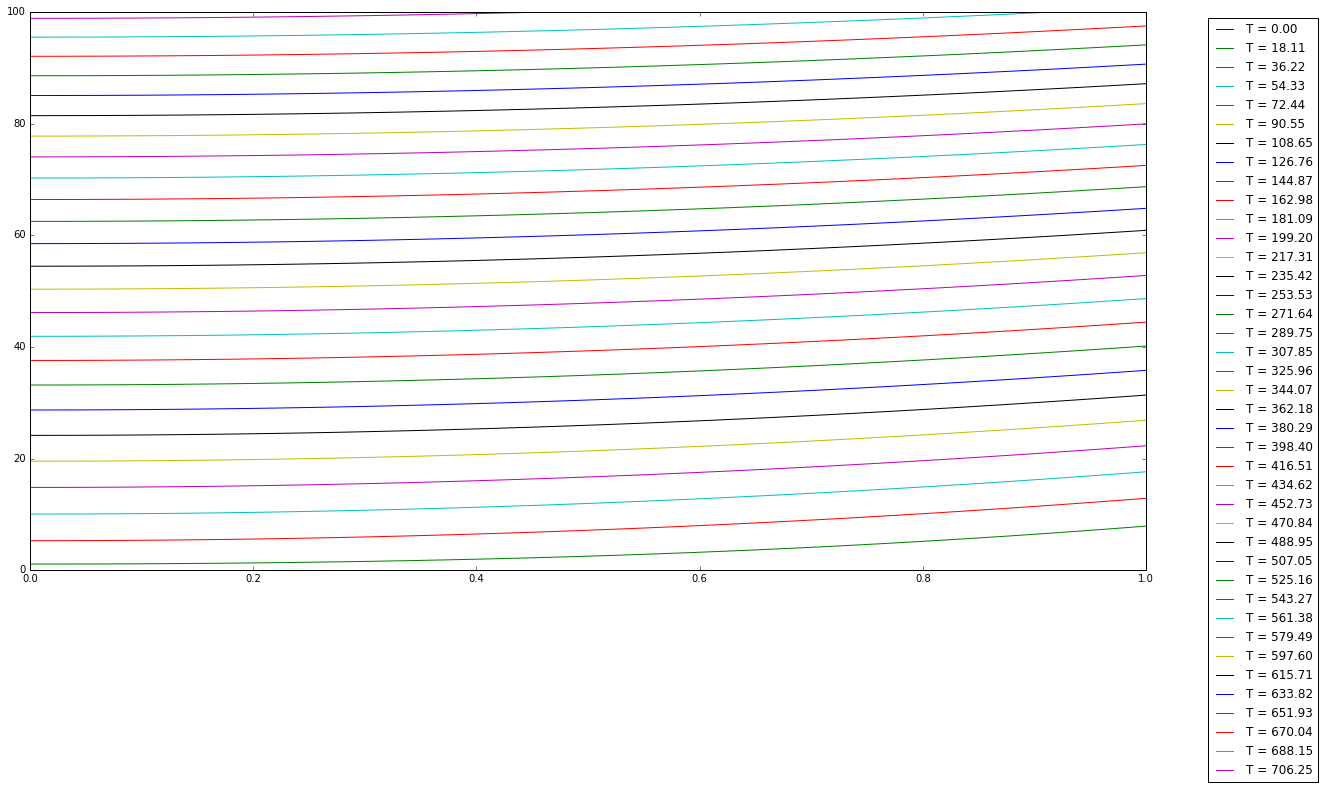

In [159]:
plt.figure(figsize=(20,10))
res, tanchor = solve(300., 0.)
print(len(res))
for i in range(len(res)):
    x = [0 + j*h for j in range(len(res[i]))]
    plt.plot(x, res[i])
#plt.legend(res[2], loc=2, bbox_to_anchor=(1.05, 1))
plt.legend(tanchor, loc=2, bbox_to_anchor=(1.05, 1))
plt.ylim(0.0, 100.0)
plt.show()

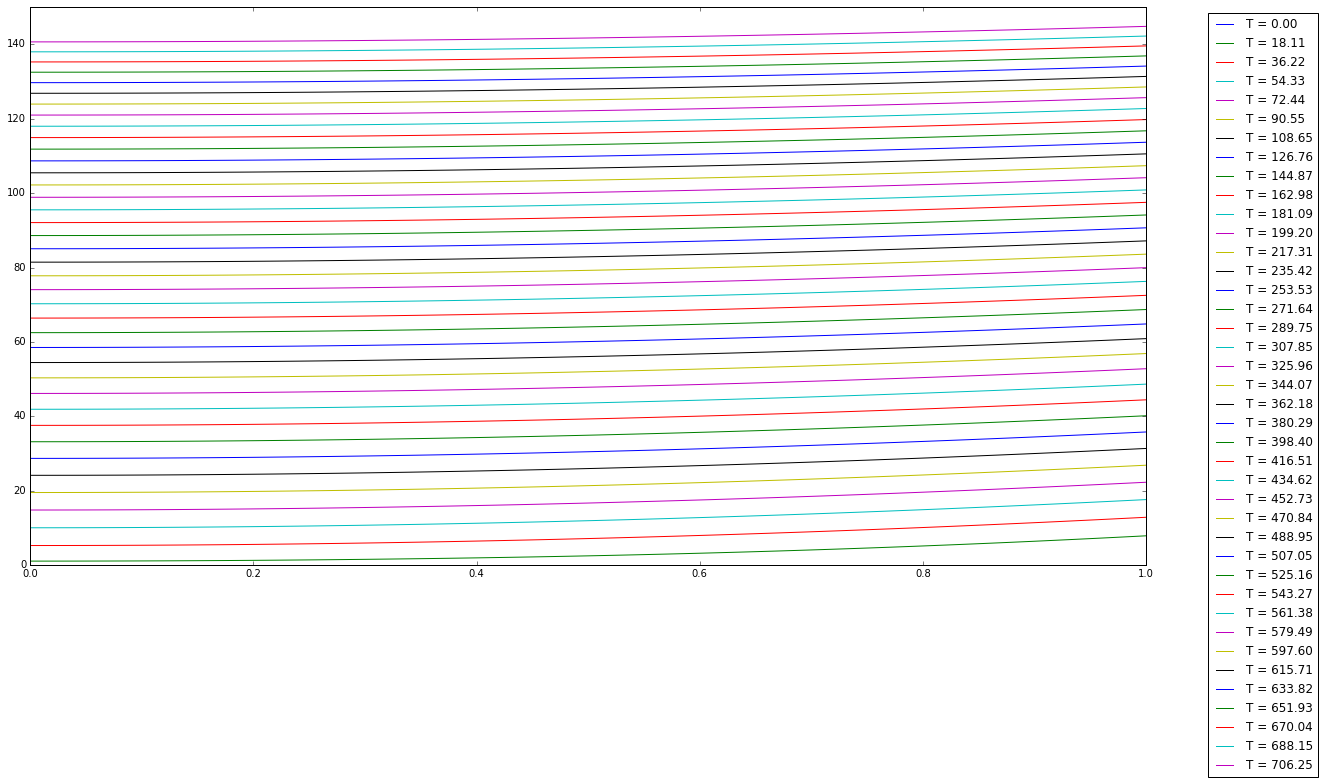

In [162]:
plt.figure(figsize=(20,10))
for i in range(len(res)):
    x = [0 + j*h for j in range(len(res[i]))]
    plt.plot(x, res[i])
#plt.legend(res[2], loc=2, bbox_to_anchor=(1.05, 1))
plt.legend(tanchor, loc=2, bbox_to_anchor=(1.05, 1))
plt.ylim(0.0, 150.0)
plt.show()